# Plotting Jazayeri & Shadlen (2010) data

Code to reproduce the plot in their paper: https://www.nature.com/articles/nn.2590.pdf

### Magdalena Bilska (s4086511)

In [3]:
from model import Model
from chunk import Chunk
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sst
import pandas as pd

In [4]:
dat = pd.read_csv("dataJS.csv")
dat.head()

,Subj,Cond,line,Trial,Ts,Tp,MaxTrial,Main
0,1,1,1,1,847.01,863.26,1489,False
1,1,1,2,2,705.84,683.01,1489,False
2,1,1,3,3,670.55,711.81,1489,False
3,1,1,4,4,847.01,829.67,1489,False
4,1,1,5,5,705.84,695.06,1489,False


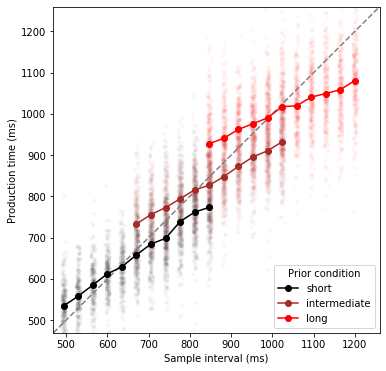

In [5]:
# Remove training trials
dat = dat[dat['Main'] == True]

# Calculate mean Tp by condition
mean_tp_by_subj = dat.groupby(['Subj', 'Cond', 'Ts'])['Tp'].mean().reset_index()
mean_tp = mean_tp_by_subj.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

# Jayazeri-Shadlen model
### Magdalena Bilska, S4086511

In [6]:
# defining all the functions from previous sessions

def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):

    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

In [7]:
# splitting the data into conditions

condition_1 = mean_tp.loc[mean_tp["Cond"] == 1]
condition_2 = mean_tp.loc[mean_tp["Cond"] == 2]
condition_3 = mean_tp.loc[mean_tp["Cond"] == 3]

In [8]:
# extracting Ts and transforming time durations into lists

durations = {}
durations["short"] = list(condition_1["Ts"])
durations["intermediate"] = list(condition_2["Ts"])
durations["long"] = list(condition_3["Ts"])

In [9]:
def experiment(train = 1000, test = 1000):
    
    m = Model()
    
    def e_block(durations):
        
        def e_trial(test = False):
            
            m.time += 1 + np.random.uniform(0.25, 0.85)
            trial_duration = random.choice(durations) #pick random trial
            m.time += trial_duration / 1000
            
            no_pulses = time_to_pulses(trial_duration) #time to pulses 
            m.add_encounter(Chunk(name = str(no_pulses), slots = {"type":"time", "no_pulses":no_pulses, "word":str(no_pulses)}))
            m.time +=0.03 #this value pronounces the effect on slope best
            
            pulses_blended = m.retrieve_blended_trace(blend_pattern, "no_pulses")
            estimated_duration = pulses_to_time(int(pulses_blended[0])) 
            m.time += estimated_duration / 1000
            
            if test == True:
                return trial_duration, estimated_duration
        
        
        blend_pattern = Chunk(name = "Time", slots = {"type":"time"})
        
        trial_durs = []
        estimated_durs = []
        
        for j in range(train): #training the prior
            e_trial()
        
        for j in range(test): #testing phase
            trial_dur_add, est_dur_add = e_trial(test=True)
            trial_durs.append(trial_dur_add)
            estimated_durs.append(est_dur_add)
        
        return [trial_durs, estimated_durs]
    
     
    out = {}
    out["short"] = e_block(durations["short"])
    out["intermediate"] = e_block(durations["intermediate"])
    out["long"] = e_block(durations["long"])
        
    return out, durations


In [10]:
out_put = {}
for i in range(10): #run experiment 10 times 
    out_put[i], durations = experiment()

In [11]:
# All data into one item 

out_put_all = {}
out_put_all["short"] = [[],[]]
out_put_all["intermediate"] = [[],[]]
out_put_all["long"] = [[],[]]

for j in range(5):
    out_put_all["short"][0].extend(out_put[i]["short"][0])
    out_put_all["short"][1].extend(out_put[i]["short"][1])
    out_put_all["intermediate"][0].extend(out_put[i]["intermediate"][0])
    out_put_all["intermediate"][1].extend(out_put[i]["intermediate"][1])
    out_put_all["long"][0].extend(out_put[i]["long"][0])
    out_put_all["long"][1].extend(out_put[i]["long"][1])

In [12]:
# Calculating mean durations of every condition

meanss = {}
for j in out_put_all:
    meanss[j] = {}
    for k in durations[j]:
        meanss[j][k] = []
    for i in range(len(out_put_all[j][0])):
        meanss[j][out_put_all[j][0][i]].append(out_put_all[j][1][i])
    
means = {}
for l in out_put_all:
    means[l] = [[],[]]
    for m in durations[l]:
        means[l][0].append(m)
        means[l][1].append(np.mean(meanss[l][m]))

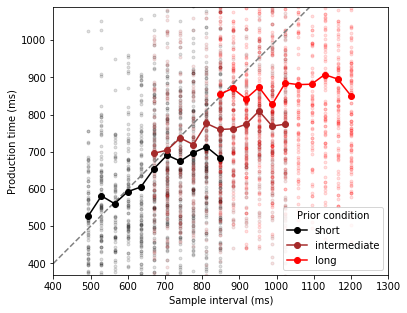

In [13]:
yrange = np.multiply((min(means['short'][1]), max(means['long'][1])), [0.7, 1.2])
f, ax = plt.subplots(figsize = (6,6))
ax.set(xlim = [400,1300], ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')
ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')
ax.plot(yrange, yrange, linestyle = '--', color ='gray')
ax.scatter(out_put_all['short'][0], out_put_all["short"][1], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(out_put_all['intermediate'][0], out_put_all["intermediate"][1], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(out_put_all['long'][0], out_put_all["long"][1], marker = '.', color = 'red', alpha = 0.025, label = None)
ax.plot(means['short'][0], means['short'][1], color = 'black', marker = 'o', label = "short")
ax.plot(means['intermediate'][0], means['intermediate'][1], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(means['long'][0], means['long'][1], color = 'red', marker = 'o', label = "long")
ax.legend(title = 'Prior condition', loc = 4)

The model is showing more inconsistent behavior (high variance) and a bias resulting in underestimating the durations (not sure why). However, the general trend can be observed, with "short" condition showing the highest slope and "long" an almost flat line. 